In [1]:
import io, keras, string, itertools, random, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.initializers import glorot_uniform, random_uniform
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, \
Dropout, Input, concatenate, Reshape
from keras import regularizers
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
# Define custom functions
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Description: Prints and plots the confusion matrix.	Normalization can be applied by setting `normalize=True`

    Args:
        - cm: Confusion Matrix
        - classes: Names of classes
        - normalize: Whether to or to not normal values in Confusion Matrix
        - cmap: Plot color
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

In [3]:
# Set model parameters
name_1 = 'mge-glove-lstm'
name_2 = 'mge-glove-cnn-lstm'
model_name = name_1
embed_dim = 300
max_seq_len = 128
drop_prob = 0.35
filter_sizes = [64,64,64]
kernels = [3,5,7]
kernel_weight = glorot_uniform(seed=50)
bias = glorot_uniform(seed=50)
kernel_reg = regularizers.l2(l=0.0001)
lstm_hidden = 1024
lstm_hidden_2 = 1024
adam_lr = 0.001
batch_size = 64
epochs = 50
valid_split = 0.3

In [4]:
# Set misc parameters
current = datetime.datetime.now()
date = current.strftime('%b-%d')
tensor_b = TensorBoard(log_dir='./tf_logs/model_{}_hidden_{}_dropout_{}_embed_dim_{}_lr_{}'.format(model_name, 
                        lstm_hidden, drop_prob,
                        embed_dim, adam_lr), 
                        batch_size=batch_size, 
                        write_graph=True, histogram_freq=0)
early_s = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
class_names = ['NA', 'Period', 'Comma', 'Question', 'Exclaim', '3-dots', 'Pad']

# Look-up table to remove punctuations from data
table = str.maketrans('', '', punctuation)

In [5]:
# Load and process input/label data
data = open('./data/processed/train.word.txt', 'r', encoding='utf-8').read()
data = data.lower()
data_split = data.split('\n')
# [-1]
data_split = data_split[:-1]

y_labels = open('./data/processed/train.label.txt', 'r', encoding='utf-8').read()
y_labels = y_labels.split('\n')
# [-1]
y_labels = y_labels[:-1]

# Check number of sequences and labels
print('Number of MGE sequences: \t{}'.format(len(data_split)))
print('Number of MGE labels: \t{}'.format(len(y_labels)))

Number of sequences: 	284436
Number of labels: 	284436


In [6]:
# Build words vocab
# Get all words in the dataset
all_data = ' '.join(data_split)
words = all_data.split()
words_in_vocab = Counter(words)
vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

# Skip most common word
vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
vocab_to_int['<pad>'] = 0  # The special value used for padding
vocab_to_int['<oov>'] = 1  # The special value used for OOVs
unique_vocab = len(vocab_to_int)
print('Number of unique words:', unique_vocab)
print('\n')

# Build labels vocab
all_labels = ' '.join(y_labels)
labels_tag = all_labels.split()
labels_in_vocab = Counter(labels_tag)
labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
label_to_int = {t: i for i, t in enumerate(labels_vocab)}
label_to_int['<pad>'] = 6  # The special value used to padding

# Check labels
no_classes = len(label_to_int)
print('Class distribution:', labels_in_vocab)
print('\n')

print('Number of unique labels:', no_classes)
print('\n')

print(Counter(label_to_int))

Number of unique words: 76055


Class distribution: Counter({'0': 5722741, '1': 582004, '2': 384732, '3': 109757, '4': 71598, '5': 30607})


Number of unique labels: 7


Counter({'<pad>': 6, '5': 5, '4': 4, '3': 3, '2': 2, '1': 1, '0': 0})


In [7]:
# Tokenize input sequences
seq_int = []
for seq in data_split:
    seq_int.append([vocab_to_int[word] for word in seq.split()])

# Pad input sequences
pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding='post', value=0)

# Check sample sequence
print('Sample sequence:', data_split[-1])
print('\n')
print('Sample sequence:', pad_seq[-1])
print('\n')

# Tokenize output labels
lab_int = []
for lab in y_labels:
    lab_int.append([word for word in lab.split()])

# Pad input labels
pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding='post', value=6)
encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

# Check sample label
print('Sample label:', pad_labels[-1])
print('\n')
print('Encoded label', encoded_labels[-1])
print('\n')

# Check max seq length
print("Maximum sequence length: {}".format(max_seq_len))
print('\n')

# Check that all sequences and labels are at max sequence length 
assert len(pad_seq)==len(seq_int)
assert len(pad_seq[0])==max_seq_len

assert len(pad_labels)==len(lab_int)
assert len(pad_labels[0])==max_seq_len
print('Sequence and labels length check passed!')

Sample sequence: what do you miss of your old life


Sample sequence: [ 23  29   6 561   7  42 190 197   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Sample label: [0 0 0 0 0 0 0 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


Encoded label [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 

In [8]:
# Split train and label dataset
train_test_split_frac = 0.8
split_index = int(0.8*len(pad_seq))

# Split data into training, validation, and test data (features and labels, x and y)
train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

# print out the shapes of your resultant feature data
print('Training/Validation Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
print('Testing Dataset: \t\t{}'.format(test_x.shape), len(test_y))

Training/Validation Dataset: 	(227548, 128) 227548
Testing Dataset: 		(56888, 128) 56888


In [9]:
# Load glove pre-trained vectors
glove_index = dict()
f = open('./data/embeddings/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_index[word] = coefs
f.close()
print('{} word vectors'.format(len(glove_index)))

embed_matrix = np.zeros((unique_vocab, embed_dim))
for word, i in vocab_to_int.items():
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector

400000 word vectors


In [10]:
def cnn_lstm(max_seq_len, unique_vocab, embed_dim, embed_matrix, filter_sizes, kernels, kernel_weight, bias):
    embed_input = Input(shape=(max_seq_len,))

    # Add embedding layer using weights from glove
    embed = Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
                        input_length=max_seq_len, trainable=True)(embed_input) #104910 * 300
    
    embed = Dropout(rate=drop_prob, seed=50)(embed)

    cnn_outputs = []
    for i in range(len(filter_sizes)):
        # Add conv1d layer
        out_i = Conv1D(filters=filter_sizes[i], kernel_initializer=kernel_weight, bias_initializer=bias, 
                          kernel_size=kernels[i], kernel_regularizer=None, activation='relu', 
                          padding='SAME', strides=1)(embed)
        out_i = BatchNormalization()(out_i)
        cnn_outputs.append(out_i)

    cnn_outputs = concatenate(cnn_outputs, axis=-1)
    cnn_outputs = Dropout(rate=drop_prob, seed=50)(cnn_outputs)
    cnn_outputs = Reshape((-1, np.sum(filter_sizes)))(cnn_outputs)
    
    dense = Dense(lstm_hidden, activation='relu')(cnn_outputs)
    dense = Dropout(rate=drop_prob, seed=50)(dense)
    
    blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(dense)
    
    blstm_outputs = Dropout(rate=drop_prob, seed=50)(blstm_outputs)
    
    output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)

    model = Model(inputs=[embed_input], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])
    
    return model

In [11]:
# Model code
model = cnn_lstm(max_seq_len=max_seq_len, unique_vocab=unique_vocab, embed_dim=embed_dim,
                embed_matrix=embed_matrix, filter_sizes=filter_sizes, kernels=kernels,
                 kernel_weight=kernel_weight, bias=bias)

# Summarize model
model.summary()

# Fit, train and evaluate model
model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, 
          epochs=epochs, validation_split=valid_split, steps_per_epoch=None, validation_steps=None,
          shuffle=True, verbose=1, callbacks=[tensor_b, early_s])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     22816500    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 64)      57664       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [12]:
plot_model(model, to_file='mge_model.png', show_shapes=True)

In [13]:
# restore = {'na': 0, 'period': 1, 'comma': 2, 'question': 3, 'exclaim': 4, '3-dots': 5, 'pad': 6}
test_data = test_x[758]
pred_x_seq = []
for x in test_data:
    for value, index in vocab_to_int.items():
        if x == index:
            pred_x_seq.append(value)

# Predicted output
pred_expand = model.predict(np.expand_dims(test_data, axis=0))
pred_y = []
for y in pred_expand:
    pred_y.append(np.argmax(y, axis=1))
print('Predictions Index:')
print(pred_y)

pred_y_seq = []
for x in pred_y:
    for y in x:
        for value, index in label_to_int.items():
            if y == index:
                pred_y_seq.append(value)

combined = []
for i in range(len(pred_x_seq)):
    if pred_y_seq[i] == '2':
        combined.append(str(pred_x_seq[i])+',')
    elif pred_y_seq[i] == '1':
        combined.append(str(pred_x_seq[i])+'.')
    elif pred_y_seq[i] == '3':
        combined.append(str(pred_x_seq[i])+'?')
    elif pred_y_seq[i] == '4':
        combined.append(str(pred_x_seq[i])+'!')
    elif pred_y_seq[i] == '5':
        combined.append(str(pred_x_seq[i])+'...')
    else:
        combined.append(str(pred_x_seq[i]))

for i in range(len(combined)):
    if '.' in combined[i]:
        combined[i+1] = combined[i+1].capitalize()
    if combined[i] == 'i':
        combined[i] = combined[i].capitalize()
    else:
        continue
        
combined = ' '.join(combined)
combined = combined.replace('<pad>', '')

print('\n')
print('Prediction sequence:')            
print(' '.join(pred_x_seq))
print('\n')
print('Prediction output:')
print(' '.join(pred_y_seq))
print('\n')
print('Combined prediction:')
print(combined.capitalize().replace('ive', "I've"))

Predictions Index:
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 1, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)]


Prediction sequence:
one of our partners who i am going to interrupt here dan come in please this is laura friedrich hello <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

[[1049201   12495   11651    1379     765     184       1]
 [  14497   80865    9223    1875    1752     123       0]
 [  21530   14815   35058    1097     690     130       0]
 [   2281    3597     929   14924     185      21       0]
 [   1525    7365    1777     321    2805      31       0]
 [   2043    2238     929     201     178     456       0]
 [      0       0       0       0       0       0 5982527]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97   1075676
           1       0.67      0.75      0.70    108335
           2       0.59      0.48      0.53     73320
           3       0.75      0.68      0.72     21937
           4       0.44      0.20      0.28     13824
           5       0.48      0.08      0.13      6045
           6       1.00      1.00      1.00   5982527

   micro avg       0.98      0.98      0.98   7281664
   macro avg       0.70      0.59      0.62   7281664
weighted avg       0.98      0.98      0.98 

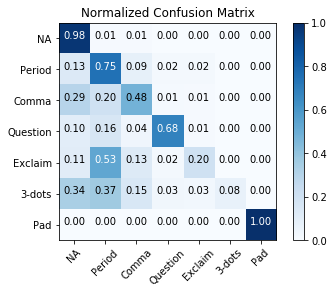

In [14]:
# Create confusion matrix and classification report
for_report = model.predict(test_x)
out_pred = [np.argmax(x, axis=1) for x in for_report]
out_pred = np.concatenate(out_pred, axis=0)

y_ = [np.argmax(x, axis=1) for x in test_y]
y_ = np.concatenate(y_, axis=0)

# print('Test dataset distribution:', counts)
cm = confusion_matrix(y_true=y_, y_pred=out_pred)
print(cm)

cr = classification_report(y_true=y_, y_pred=out_pred)
print(cr)

plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

In [15]:
# comma, period, question, exclaim, 3-dots
overall = classification_report(y_true=y_, y_pred=out_pred, output_dict=True)
precision = []
recall = []
f1 = []

for i in range(2, 7):
    precision.append(overall[str(i)]['precision'])
    recall.append(overall[str(i)]['recall'])
    f1.append(overall[str(i)]['f1-score'])

print('Comma, Period, Question Precision:\t{:.3f}'.format(np.average(precision[:3])))
print('Comma, Period, Question Recall:\t\t{:.3f}'.format(np.average(recall[:3])))
print('Comma, Period, Question F1-Score:\t{:.3f}'.format(np.average(f1[:3])))
print('\n')

print('Overall Precision:\t{:.3f}'.format(np.average(precision)))
print('Overall Recall:\t\t{:.3f}'.format(np.average(recall)))
print('Overall F1-Score:\t{:.3f}'.format(np.average(f1)))

Comma, Period, Question Precision:	0.594
Comma, Period, Question Recall:		0.454
Comma, Period, Question F1-Score:	0.507


Overall Precision:	0.653
Overall Recall:		0.487
Overall F1-Score:	0.530
